In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

# FFT method: One-way wave equation 

In [2]:
c = 2            # Wave speed
L = 20           # Length domain
N = 100          # Number of points
delta_x = L/N    # Step size

x = np.arange(-L/2, +L/2, delta_x)
print(x.shape)

(100,)


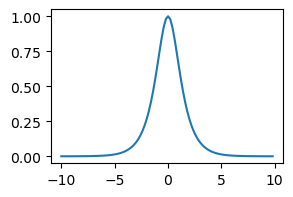

In [3]:
# Initial conditions
rho_0 = 1/np.cosh(x)

plt.figure(figsize = (3,2))
plt.plot(x, rho_0)
plt.show()

### Simulation in Fourier (k) space

In [5]:
# Wavenumbers - spatial frequencies
k_numbers = 2*np.pi*np.fft.fftfreq(len(x), d = delta_x)
print(k_numbers.shape)

(100,)


In [6]:
# FFT of the initial condition
rho_0_hat = np.fft.fft(rho_0)

# Norm of the Fourier transform
amp_rho_0_hat = np.abs(rho_0_hat/(rho_0_hat.size//2))

<function matplotlib.pyplot.show(close=None, block=None)>

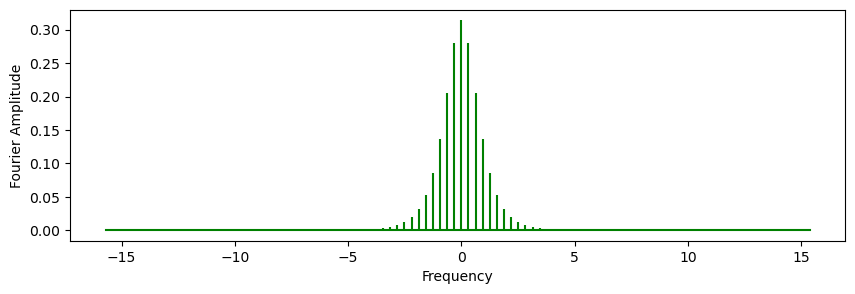

In [20]:
# Plotting

plt.figure(figsize = (10,3))
plt.stem(k_numbers, amp_rho_0_hat, "g", markerfmt = " ", basefmt = "g")
plt.xlabel("Frequency")
plt.ylabel("Fourier Amplitude")
plt.show

Next we concatenate real and complex array for the ODE integrators.

In [22]:
rho_0_conc = np.concatenate((rho_0_hat.real, rho_0_hat.imag))
print(rho_0_hat.shape, rho_0_conc.shape)

(100,) (200,)


In [24]:
# Time discretization
t_step = 0.025
m = 100
t = np.arange(0, m*t_step, t_step)
print(t.shape)

(100,)


### RHS ODE 

In [27]:
# Construction of the right-hand side of ODE

def RHS_ODE(rho_0_conc, t, k_numbers, c):
    u_tilde = rho_0_conc[:N] + (1j)*rho_0_conc[N:]
    rhs_u_tilde = -(1j)*c*k_numbers*u_tilde
    rhs_ode = np.concatenate((rhs_u_tilde.real, rhs_u_tilde.imag))
    
    return rhs_ode

### Solve

In [26]:
import scipy.integrate as sint

In [28]:
# Call the ODE integrator 

solution = sint.odeint(RHS_ODE, rho_0_conc, \
                      t, args = (k_numbers, c))
print(solution.shape)

(100, 200)


### Complex solution reconstruction

In [30]:
rho_solution = solution[:,:N] + (1j)*solution[:,N:]
print(rho_solution.shape)

(100, 100)


### Inverse Fourier transform of each right-hand side solution

In [31]:
inv_rho_solution = np.zeros(rho_solution.shape,\
                           dtype = complex)

for k in range(len(t)):
    inv_rho_solution[k,:] = np.fft.ifft(rho_solution[k,:])

print(inv_rho_solution.shape)

(100, 100)


## Ploting the solution

Text(0, 0.5, 'Density')

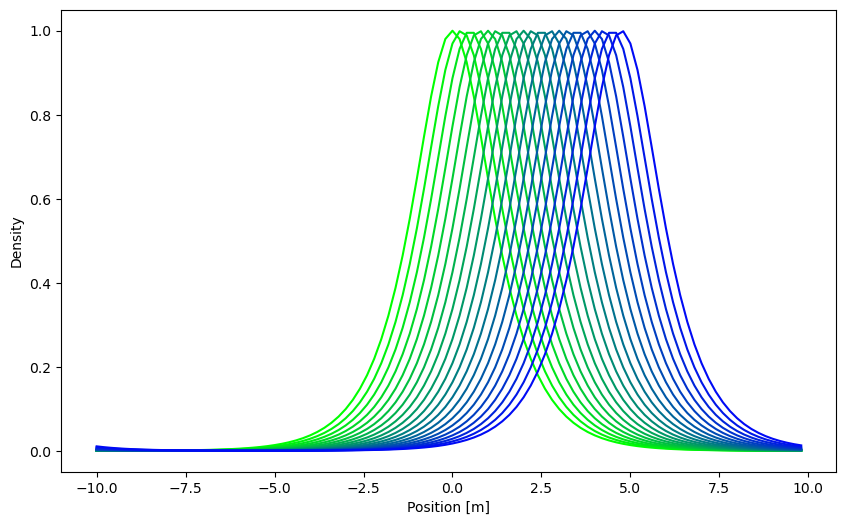

In [55]:
# Add colour

G= np.linspace(1,0,m)
R= 0
B = np.linspace(0,1,m)

plt.figure(figsize = (10,6))
for j in range(0, m, 5):
    plt.plot(x, inv_rho_solution[j,:], color = [R,G[j],B[j]])
    
plt.xlabel("Position [m]")
plt.ylabel("Density")

## Surface plot

In [37]:
from mpl_toolkits.mplot3d import axes3d

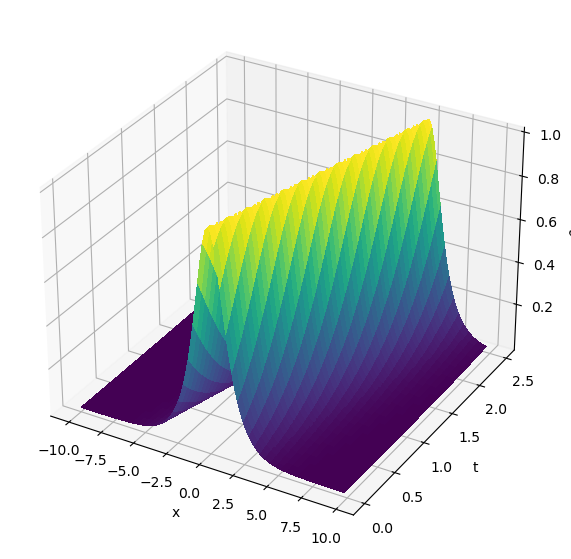

In [56]:
# Grid
x_grid, t_grid = np.meshgrid(x, t)

fig = plt.figure(figsize = (12,7))

ax = plt.axes(projection = "3d")
ax.plot_surface(x_grid, t_grid, inv_rho_solution.real, cmap = "viridis", linewidth = 0, antialiased = False)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel(r'$\rho$')

plt.show()

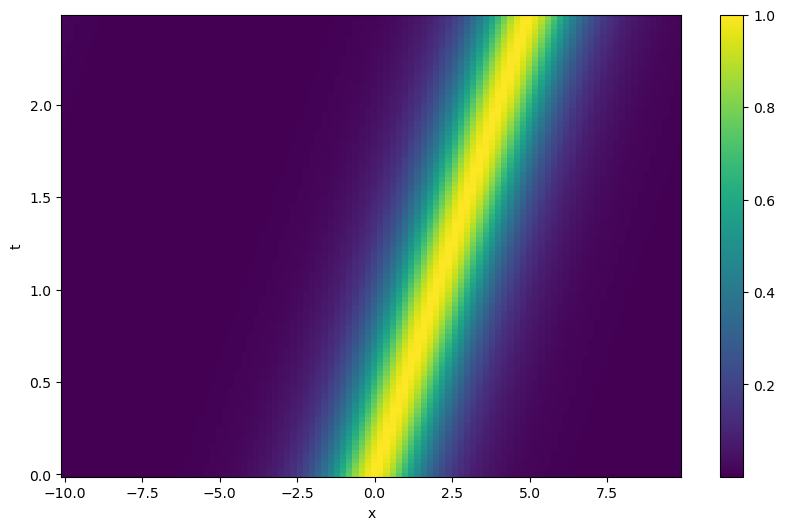

In [57]:
plt.figure(figsize = (10,6))

z = plt.pcolor(x_grid, t_grid, inv_rho_solution.real, cmap = 'viridis')
plt.colorbar(z)

plt.xlabel('x')
plt.ylabel('t')

plt.show()

## Animation 

In [88]:
for j in range(m):
    inv_rho_first_j = inv_rho_solution.real[:j, :]
    inv_rho_zero_remainder = np.zeros_like(inv_rho_solution.real[j:, :])
    inv_rho_combined = np.concatenate((inv_rho_first_j, inv_rho_zero_remainder), axis=0)
    
    # First subplot: pcolor plot
    plt.figure(figsize=(14, 6))

    # First subplot: pcolor plot
    plt.subplot(1, 2, 1)
    z = plt.pcolor(x_grid, t_grid, inv_rho_combined, cmap='viridis')
    plt.colorbar(z)
    plt.xlabel('x')
    plt.ylabel('t')

    # Second subplot: line plot
    plt.subplot(1, 2, 2)
    plt.plot(x, inv_rho_solution[j, :], color='magenta')
    plt.xlabel('Position [m]')
    plt.ylabel('Density')

    plt.tight_layout()  
    plt.savefig('wave(1D){:03}.png'.format(j))
    plt.close()


In [89]:
import glob
from PIL import Image

In [90]:
images_in = 'wave****.png'
gif_image_out = 'animation_wave.gif'
imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))
img = next(imgs)
img.save(fp = gif_image_out, format = 'GIF', append_images = imgs, save_all = True, duration = 100, loop =0)